# dQA implementation with Numpy (full)


dated: 15 march 2022

In [1]:
import quimb as qu
import quimb.tensor as qtn

import numpy as np
import numpy.fft as fft

import matplotlib.pyplot as plt

from tqdm import tqdm

# custom functions
from tenn import *

In [2]:
# parameters of the dQA

N = 21     # number of spins/sites/parameters/qubits  (21)
P = 100    # total number of QA steps  // should be 100/1000
dt = 1     # time interval  (1 or 0.1)

# tau (annealing time) will be fixed as P*dt

max_bond = 10  # MPS max bond dimension

N_xi = 17  # dataset size (number of patterns)  17

### general tools

In [3]:
def create_dataset(N : int, features : int):
    """Create dataset as described by ref. paper, i.e. random +-1 values."""
    x = np.random.randint(2, size=(N, features))
    x[ x == 0 ] = -1  # data is encoded as +- 1
    return x

### time evolution operators

In [4]:
def make_Ux(N, beta_p, dtype = np.complex128):
    """Return as MPO the U_x evolution operator at time-parameter beta_p."""

    tb = np.array( [[np.cos(beta_p), 1j*np.sin(beta_p)],[1j*np.sin(beta_p), np.cos(beta_p)]], dtype=dtype)
    return [ np.expand_dims(tb, axis=(0,1)) for _ in range(N) ]

In [20]:
def Wz(N, Uk : np.array, xi : int, marginal = None, dtype = np.complex128):
    """The tensors of Eq. 17 of reference paper."""
    
    bond_dim = len(Uk)

    if marginal == 'l':
        shape = (1,bond_dim,2,2)
    elif marginal == 'r':
        shape = (bond_dim,1,2,2)
    else:
        shape = (bond_dim,bond_dim,2,2)

    tensor = np.zeros( shape, dtype = dtype )

    coeff = np.power( Uk/np.sqrt(N+1), 1/N)
    exx = 1j * np.arange(bond_dim) * np.pi / (N + 1)    # check: N+1

    for kk in range(bond_dim):
        spin_matrix = np.diag(
            [ coeff[kk]*np.exp(exx[kk]*(1-xi)), 
              coeff[kk]*np.exp(exx[kk]*(1+xi)) ] 
        )
        if marginal == 'l':
            tensor[0,kk,:,:] = spin_matrix
        elif marginal == 'r':
            tensor[kk,0,:,:] = spin_matrix
        else:
            tensor[kk,kk,:,:] = spin_matrix

    return tensor

In [21]:
def make_Uz(N : int, Uk : np.array, xi : np.array, bond_dim=None, dtype = np.complex128):
    """Return as MPO the U_z evolution operator at time s_p (defined indirectly by Uk)."""

    # Uk must be a vector for all k values, while p is fixed 
    # xi must be a single sample from dataset
    
    assert len(xi) == N, 'not matching dims'

    arrays = [ Wz(N, Uk, xi[0], marginal = 'l', dtype = dtype) ] + \
             [ Wz(N, Uk, xi[i+1], dtype = dtype) for i in range(N-2) ] + \
             [ Wz(N, Uk, xi[N-1], marginal = 'r', dtype = dtype) ]

    return arrays

### hamiltonian evaluation

In [22]:
def h_perceptron(m, N):
    """ Cost function to be minimized in the perceptron model, depending on the overlap m.
        The total H_z Hamiltonian is obtained as a sum of these cost functions evaluated at each pattern csi_mu.

        h(m) = 0 if m>=0 else -m/sqrt(N)
    """
    m = np.array(m)
    return np.where(m>=0, 0, -m/np.sqrt(N)).squeeze()

def f_perceptron(x, N):
    """ Cost function to be minimized in the perceptron model, depending on the Hamming distance x.
        The total H_z Hamiltonian is obtained as a sum of these cost functions evaluated at each pattern csi_mu.

        f(x) = h(N - 2x) = h(m(x)) with m(x) = N - 2x
    """

    m = N - 2*np.asarray(x)
    return h_perceptron(m, N)

In [23]:
fx_FT = fft.fft(f_perceptron(range(N+1), N), norm="ortho")

def Hz_mu_singleK(N, mu, K, f_FT_, patterns, dtype=np.complex128):
    """ Build factorized Hz^{mu,k} (bond dimension = 1) on N sites"""

    Hz_i = []
    for i in range(N):
        tens = np.zeros((1,1,2,2), dtype=dtype)
        for s_i in range(2):
            tens[0,0,s_i,s_i] = np.power(f_FT_[K]/np.sqrt(N+1), 1/N) * \
                np.exp( 1.0j * (np.pi/(N+1)) * K *\
                        (1-patterns[mu,i]*((-1)**s_i)) )
        Hz_i.append(tens) # removed copy

    return Hz_i

# this is really the same!
def Hz_mu_singleK(N, mu, K, f_FT_, patterns):
    """ Build factorized Hz^{mu,k} (bond dimension = 1) on N sites"""

    d = 2
    Hz_i = []
    for i in range(1,N+1):
        tens = np.zeros((1,1,d,d), dtype=np.complex128)
        for s_i in range(d):
            tens[0,0,s_i,s_i] = np.power(f_FT_[K]/np.sqrt(N+1), 1/N) * np.exp(1.0j * (np.pi/(N+1)) * K * (1-patterns[mu,i-1]*(-1)**s_i))
        Hz_i.append(tens.copy())

    #Hz = qtn.MPO_product_operator(Hz_i)#, upper_ind_id='u{}', lower_ind_id='s{}')
    return Hz_i

In [24]:
def compute_loss(psi, N, fxft, xi):
    N_tens = len(psi)
    eps = 0.0
    for mu in range(N_xi):
        for kk in range(N+1):
            mpo = Hz_mu_singleK(N, mu, kk, fxft, xi)  # TODO store for once

            psiH = apply_mpsmpo(psi, mpo)

            E = braket(psiH, psi)

            eps += E/N_tens
    return eps[0,0]

## run

In [25]:
#xi = create_dataset(N = N_xi, features = N)  # mu in (0, N_xi-1)
#   eventually save it: np.savetxt('dataxi.txt', xi, fmt='%i')

xi = np.loadtxt('dataxi.txt')

# this is the initial state, an MPS of bond_dim = 1

psi = [ np.array([[[2**-0.5], [2**-0.5]]], dtype=np.complex128) ] * N

tau = dt * P

E_gs = -N/2 # guess...

# keep track of loss function
loss = []


# etc
cc = []

In [26]:
psi[0].shape

(1, 2, 1)

In [27]:
# fourier transform of U_z -> U_k
Uk_FT = np.zeros((N+1,P), dtype=np.complex128)

for p in range(0,P):
    Uk_FT[:,p] = fft.fft( np.exp(-1.0j*((p+1)/P)*dt*f_perceptron(range(N+1), N)), norm="ortho")

In [28]:
compute_loss(psi, N, fx_FT, xi)

(0.3268194661061795+1.0581813203458523e-15j)

In [29]:
crop_p = None

loss.append( (0, compute_loss(psi, N, fx_FT, xi)) )

print('dQA---')
print(' tau = {}, P = {}, dt = {}'.format(tau, P, dt) )

if crop_p is not None:
    print(' [!] simulation will be stopped at iter', crop_p)


#  finally... RUN!
with tqdm(total=P, desc='QAnnealing') as pbar:

    for pp in range(P):

        s_p = (pp+1)/P
        beta_p = (1-s_p)*dt
        #gamma_p = s_p*dt    # not needed
    
        # loop over patterns
        for mu in range(N_xi):
            #print('mu =', mu)

            #  QUIMB approach -------------------------------
            #Uz = make_Uz(N, Uk_FT[:,pp], xi[mu])
            ##psi = Uz._apply_mps( psi, compress = False)
            #psi = apply_compress(Uz, psi, max_bond=max_bond, method='svd')


            #  CUSTOM approaches ----------------------------
            Uz = make_Uz(N, Uk_FT[:,pp], xi[mu])
            #psi = Uz._apply_mps( psi, compress = False)
            psi = apply_mpsmpo(psi, Uz)
            # prepare MPS as list of tensors for numpy manipulations
            #stato = [ el.data for el in psi.tensors ]

            #  BUH !!!!!!!!!!!!!!!!!!!!!!!!!
            #   I just had this block, marked it as working but IDK... it is 
            #  an old implementation with first SVD function (naive, maybe)
            #if False:
            #    rstato = right_canonicalize(stato, 1, normalize = True)
            #    compr = compress_svd(rstato, max_bond)
            #    
            #    compr[0] = np.expand_dims(compr[0], 0)
            #    compr[-1] = np.expand_dims(compr[-1], 1)
            #    normalize_mps(compr)
            #    
            #    compr[0] = compr[0][0]
            #    compr[-1] = compr[-1][:,0,:]
                
            

            #  Numpy SVD: first compress, then right canonicalize
            #  
            #  status: works, it is fast (1.8s/it) but has fluctuations of loss
            if True:
                #stato[0] = np.expand_dims(stato[0], 0)
                #stato[-1] = np.expand_dims(stato[-1], 1)

                #stato = convert(stato)

                buh = compress_svd_normalized(psi, max_bd=max_bond)
                psi = right_canonicalize(buh, 1, normalize = True) # makes loss much more stable

                #compr = convert(compr)

                #compr[0] = compr[0][0]
                #compr[-1] = compr[-1][:,0,:]


            #  Numpy SVD: first right canonicalize, then compress
            #  
            #  status: works, it is slow (10s/it) but loss is more stable
            if False:
                stato[0] = np.expand_dims(stato[0], 0)
                stato[-1] = np.expand_dims(stato[-1], 1)

                stato = convert(stato)
                
                buh = right_canonicalize(buh, 1, normalize = True) # makes loss much more stable
                compr = compress_svd_normalized(stato, max_bd=max_bond)

                compr = convert(compr)

                compr[0] = compr[0][0]
                compr[-1] = compr[-1][:,0,:]
                
            #  Numpy Variational compression
            #
            #  status: not working. slow as hell, problems with normalization
            if False:
                stato[0] = np.expand_dims(stato[0], 0)
                stato[-1] = np.expand_dims(stato[-1], 1)
                buh = compress_svd_normalized(stato, max_bd=max_bond)

                buh[0] = buh[0][0]
                buh[-1] = buh[-1][:,0,:]

                compr = variational_compression(buh, max_bond, N_sweep = 4, guess = None)
                
            
            # revert to Quimb...
            #psi = qtn.tensor_1d.MatrixProductState( compr )
            #psi.normalize()

            curr_bdim = psi[int(N/2)].shape[0]
            cc.append( curr_bdim )

        Ux = make_Ux(N, beta_p = beta_p)
        #psi = Ux.apply( psi, compress = False)
        psi = apply_mpsmpo(psi, Ux)

        # evaluate  <psi | H | psi>
        expv = compute_loss(psi, N, fx_FT, xi)
        loss.append( (s_p, expv) )

        # etc
        pbar.update(1)
        pbar.set_postfix_str("loss = {}, bd = {}".format( np.round(expv, 5), curr_bdim ) )
        
        if crop_p is not None:
            if pp == crop_p:   break

dQA---
 tau = 100, P = 100, dt = 1


QAnnealing: 100%|██████████| 100/100 [04:45<00:00,  2.85s/it, loss = (0.00428+0j), bd = 10]


In [31]:
for el in psi:
    print(el.shape)

(1, 2, 2)
(2, 2, 4)
(4, 2, 7)
(7, 2, 9)
(9, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2, 1)


#### plot

/home/baronefr/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


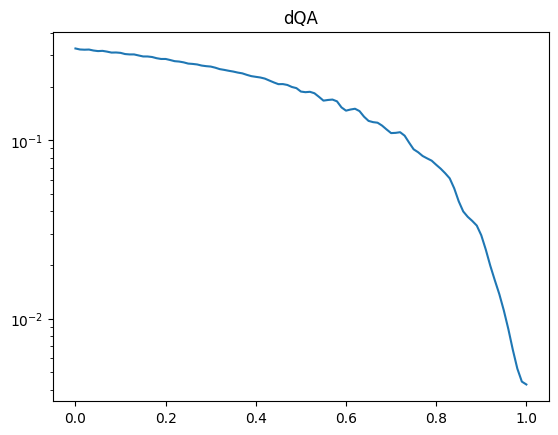

In [32]:
plt.plot( *zip( *np.real_if_close(loss) ) )
plt.yscale('log')
plt.title('dQA')
plt.show()

In [33]:
# final loss evaluation
loss[-1]

(1.0, (0.004278655064162001+6.817463260588852e-16j))

Text(0.5, 1.0, 'loss monitor')

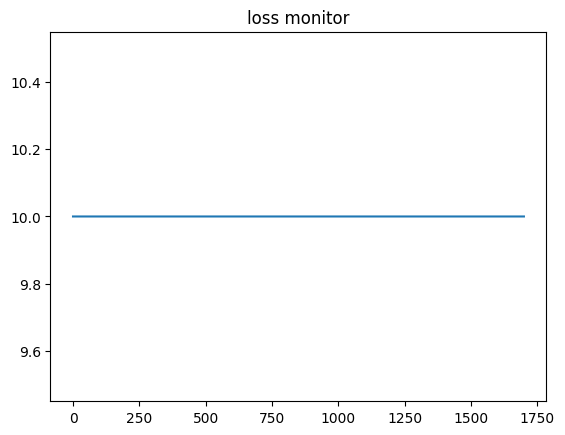

In [35]:
plt.plot(cc)
plt.title('loss monitor')